# 7장 에이다부스트 메타 알고리즘으로 분류 개선하기
---
    - 메타 알고리즘 / 앙상블 메쏘드
    
    다양한 분류 알고리즘을 결합하는 방법
    1) 하나의 알고리즘으로 설정을 다르게하여 적용
    2) 데이터 집합의 서로 다른 부분을 서로 다른 분류기에 적용
     
## 7.1 데이터 집합의 다양한 표본을 사용하는 분류기
---

### 7.1.1 배깅:임의로 추출한 재표본 데이터로부터 분류기 구축하기
---
    - 배깅(Bagging): 다양한 분류기를 통합하는 방법
    
    데이터로부터 데이터 크기의 샘플을 복원으로 S번 추출하여 샘플을 S개 생성
    S개를 통하여 Classifier를 형성한 후
    새로운 데이터들이 나타난나면 그 Classifier들로 Majority Vote
    예) Random Forests

![im](0.png)

### 7.1.2 부스팅
---
    - 부스팅
    다양한 분류기가 순차적으로 훈련
    각 분류기는 이전 분류기의 오분류된 샘플에 집중하여 훈련
    이 분류기들의 가중합
    예) Adaboost
    
    - 에이다부스트
    수집 - 준비 - 분석 - 훈련 - 검사 - 사용
    장점: 오류율이 낮고 코드가 쉽다. 가장 좋은 분류기를 가지고 분류하며, 조절을 위한 매개변수가 없다.
    단점: 오류 데이터(Outliers)에 민감하다.
    활용: 수치형 값, 명목형 값
    

## 7.2 훈련: 오류에 초점을 맞춘 분류기 개선
---
    - 약한 분류기: 오류율이 50보다는 낮음
    - 강한 분류기: 오류율이 매우 낮음
    
    - 에이다부스트(Adaptive Boosting)
    한 종류의 가중치가 데이터에 순차적으로 적용된다. (가중치 벡터 D)
![im](1.png)    

$\varepsilon  = \frac{number of incorrectly classified examples}{Total number of examples}$

$\alpha = \frac{1}{2}ln\left( \frac{1-\varepsilon}{\varepsilon}\right)$
    
![im](2.png)    

맞게 예측하면
${{D}_{i}}^{(t+1)}=\frac{{{D}_{i}}^{(t)}{e}^{-\alpha}}{Sum(D)}$

틀리게 예측하면
${{D}_{i}}^{(t+1)}=\frac{{{D}_{i}}^{(t)}{e}^{\alpha}}{Sum(D)}$

    - PML
![im](3.png)    


## 7.3 의사결정 스텀프로 약한 학습기 생성
---
    - Decision Stump
    의사결정 나무의 한 줄기(한가지 특성)
        
![im](4.png)


In [2]:
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels
datMat, classLabels = loadSimpData()

In [5]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal) #call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

D = mat(ones((5,1))/5)
buildStump(datMat, classLabels, D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 7.4 전체 에이다부스트 알고리즘 구현하기
---


In [8]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print "total error: ",errorRate
        if errorRate == 0.0: break
    return weakClassArr

classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

classifierArray

total error:  0.2
total error:  0.2
total error:  0.0


[{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alpha': 0.8958797346140273,
  'dim': 0,
  'ineq': 'lt',
  'thresh': 0.90000000000000002}]

## 7.5 검사: 에이다부스트로 분류하기
---

In [9]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        print aggClassEst
    return sign(aggClassEst)
datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)
adaClassify([0, 0], classifierArr)

total error:  0.2
total error:  0.2
total error:  0.0
[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

## 7.6 예제: 에이다부스트에 복잡한 데이터 집합 적용하기
---


In [8]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
errArr = mat(ones((67, 1)))
errArr[prediction10 != mat(testLabelArr).T].sum()

total error:  0.284280936455
total error:  0.284280936455
total error:  0.247491638796
total error:  0.247491638796
total error:  0.254180602007
total error:  0.240802675585
total error:  0.240802675585
total error:  0.220735785953
total error:  0.247491638796
total error:  0.230769230769


16.0

    - 분류기의 개수와 과적합

![im](5.png)

    적당한 개수에서 검사오류가 안정기(plateau)에 도달한다.

## 7.7 분류 불균형
---

### 7. 7. 1  또 다른 성능 측정 방법: 정확도, 재현율 그리고 ROC

    - Confusion Matrix
![im](6.png)

    - 예측 vs 현실
![im](7.png)

    - 정확도 = TP/(TP+FP)
    - 재현율 = TP/(TP+FN)
    - ROC곡선 (Receive operating characteristic)
![im](8.png)
    이익에 대한 비용을 고려한 의사결정이 가능
    
    - AUC (Area Under the Curve)
    0.5 ~ 1

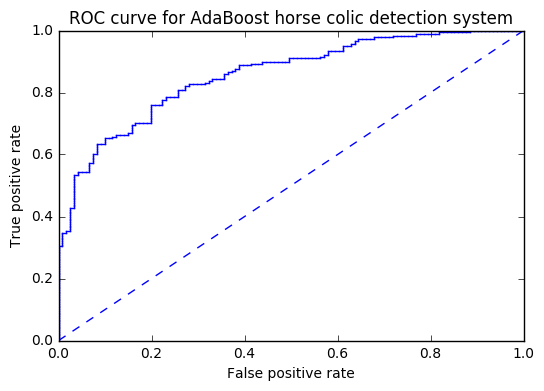

the Area Under the Curve is:  0.858296963506


In [13]:
%matplotlib inline
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   #init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print "D:",D.T
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        #print "classEst: ",classEst.T
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        #print "aggClassEst: ",aggClassEst.T
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
#         print "total error: ",errorRate
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst

def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print "the Area Under the Curve is: ",ySum*xStep
    
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

### 7. 7. 2 비용 함수를 가진 분류기의 의사결정 다루기

    - 비용 민감 학습
    비용을 학습에 반영
![im](9.png)
    예)
    비용 함수를 기반으로 벡터 D조절


### 7. 7. 3 분류 불균형이 있는 데이터를 처리하기 위한 데이터 샘플링

    - 언더샘플링: 예제의 일부를 제거
    - 오버샘플링: 예제를 중복해서 사용
    예)
    카드 사기처럼 드물게 발생하는 경우
    정상: 4950
    사기: 50
    사기 -> 오버샘플링
    정상 -> 언더샘플링
    과적합의 위험이 있음
    